# CONTROLLING CANCER WITH VITAMINS
(Based on a final project submitted by Jacob Evarts to BIOEN 599, March, 2024, University of Washington)

# Preliminaries

In [ ]:
# Set to True if running in colab
if False:
    # The following cell may have to be run twice, the second time using "Restart session and runall".
    !pip install control==0.9.4
    !pip install controlSBML

In [1]:
import control
import controlSBML as ctl
import numpy as np

# Helpers

In [2]:
TIMES = np.linspace(0, 30, 300)
FIGSIZE = (5, 5)

# 1. Problem statement & system definition

Cancer and its causes is a field that has recieved much attention, and mitigating the chance of cancer with lifestyle changes is ideal over other more invasive treatments. [This model](https://www.ebi.ac.uk/biomodels/BIOMD0000001042#Overview) investigates how the consumptions of vitamins in the diet affects the progression of a tumor in a healthy cell context. The authors claim that different combinations of vitamins can keep healthy cells alive where they would otherwise be wiped out by the tumor cell population. Therefore, the model input is vitamins and the output species of interest are healthy and tumor cells. The control objectives will be:
1. Maximize healthy cell growth over the vitamin treatement.
    - This will result in decreasing tumor cells because of competition.
2. Minimize oscilations, as population collapse and rebound is not ideal in a living system.
3. The vitamin operating range will be [0, 10] (high levels of vitamins could be incur unacceptable levels of toxicity).

If these objectives can be achieved it would give insight into a dietary intervention for cancer that could be prevent more serious later stage cases.

## System Exploration

Here we explore the relationship between the key entities in the model: tumor cells, normal cells, and vitamins.

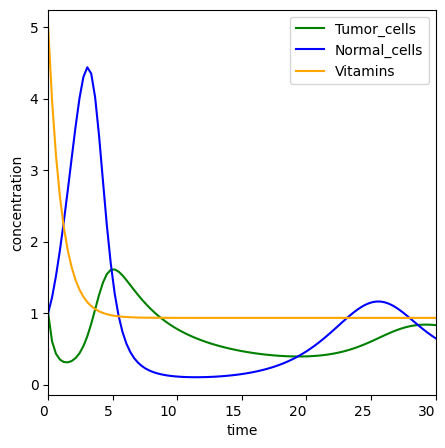

In [21]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2108260003/3/Alharbi2019%20TNVM.xml"
CTLSB = ctl.ControlSBML(URL, times=np.linspace(0, 30, 100), is_fixed_input_species=True, figsize=FIGSIZE)
_ = CTLSB.plotModel(figsize=FIGSIZE, selections=["Normal_cells", "Tumor_cells", "Vitamins"])

These plots are not controlled experiments and so it's difficult to see the relationship between vitamins and normal cells. For example, the dramatic drop in vitamins *may* becausing the increase in healthy cells. But we need another study to make this connection.

## Staircase response for healthy cells

The staircase response provides a constant influx of vitamins at different levels to assess the impact on the population of normal cells.

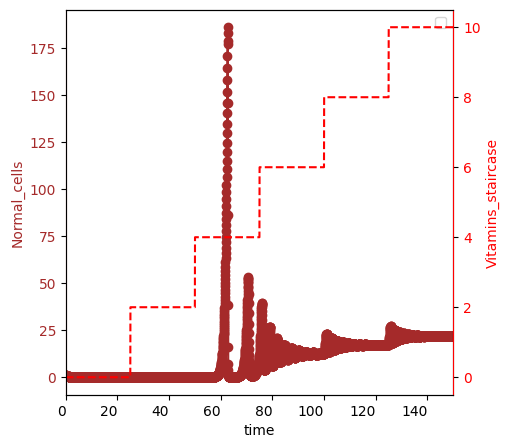

In [4]:
CTLSB.setSystem(input_name="Vitamins", output_name="Normal_cells", is_fixed_input_species=True)
_ = CTLSB.plotStaircaseResponse(initial_value=0, final_value=10,
                               times=np.linspace(0, 150, 5000))

In [5]:
# Constants based on staircase response
TIMES = np.linspace(0, 150, 1500)
INITIAL_VALUE = 2
FINAL_VALUE = 6

INPUT = "Vitamins"
OUTPUT = "Normal_cells"

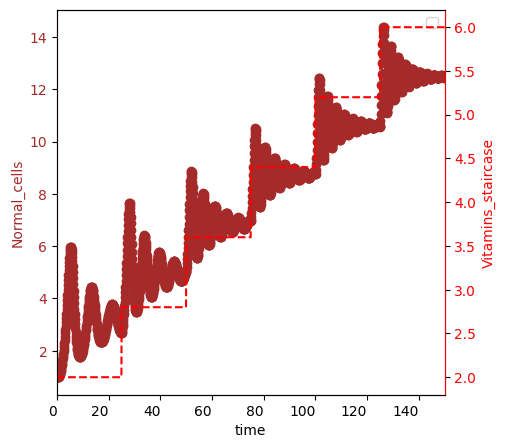

In [6]:
CTLSB.setSystem(input_name=INPUT, output_name=OUTPUT)
_ = CTLSB.plotStaircaseResponse(initial_value=INITIAL_VALUE, 
                                times=TIMES, final_value=FINAL_VALUE)

## System Summary

A system is defined by its inputs, outputs, the range of their values, and how the input affects the output.

1. SBML model: https://www.ebi.ac.uk/biomodels/services/download/getfiles/MODEL2108260003/3/Alharbi2019%20TNVM.xml

2. Output: Normal_cells

3. Input: Vitamins

4. Direction effect of input: Increasing oscilatory 

5. Operating region: [2, 6]

6. Range of outputs that can be achieved: [0, 5.5]

Both cell types have similar responses to stepping up the vitamin concentration. It is worth noting that with a static vitamin concentration of 0, the healthy cells will completely die out and the cancer cells will propagate. It appears that when vitamin concentration increases there is an initial growth of healthy cells, which after a short lag is followed by the growth of tumor cells. With this in mind it would be interesting to try a series of vitamin interventions as opposed to keeping the level constant, which would also better represent the real effects of eating meals over time with vitamins. 

# 2. System identification

System identification is a curve fitting procedure that constructs a transfer function that relates values of the input to those of the output. As before, we use a staircase of input values.

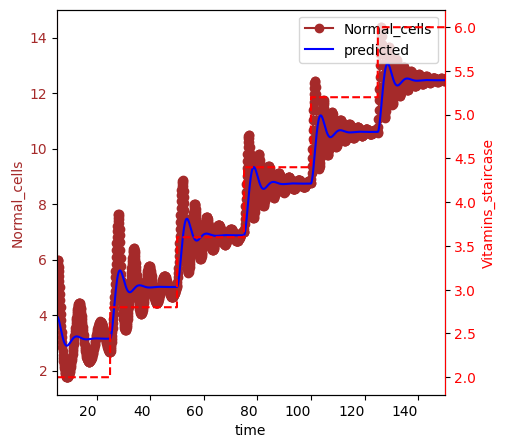

In [7]:
results = CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=2, fit_start_time=5, figsize=FIGSIZE,
                                       times=TIMES, fitter_method="poly",
                                       initial_value=INITIAL_VALUE,
                                       final_value=FINAL_VALUE)
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()

In [8]:
TRANSFER_FUNCTION

TransferFunction(array([933.88572125]), array([481.8624676 , 299.92739544, 401.10824994]))

In [9]:
TRANSFER_FUNCTION.poles()

array([-0.31121681+0.85764585j, -0.31121681-0.85764585j])

# 3. Control design

## Testbed construction

We can construct the closed loop system and plot the result.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


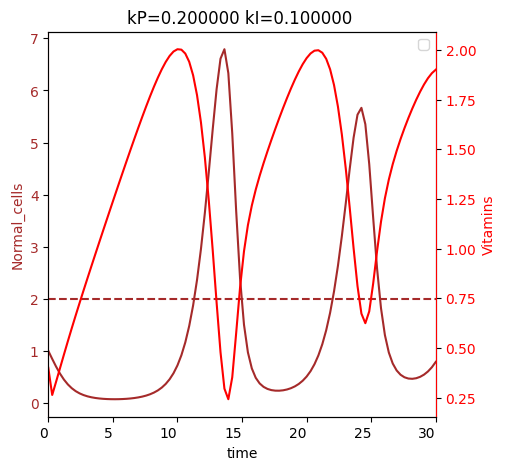

In [10]:
_ = CTLSB.plotDesign(setpoint=2, kP_spec=0.2, kI_spec=0.1, min_parameter_value=1,
                max_parameter_value=100, ylabel="Normal_cells")

Of the six reactions that take place in this model, they are all either synthesis or degradation reactions. It is interesting to not the coupling between the tumor and normal cell growth equations. In particular, healthy cells decrease as a function of healthy cells as well as tumor cells:
$\gamma * N * T$
Where $\gamma$ is a growth parameter, N is the number of healthy cells, and T is the number of tumor cells. In addition, tumor cells increase as a function of healthy cells:
$\alpha_1 * T * (1 - \alpha_2 * T) + \beta_2 * N * T$
Where the $\alpha$ 's and $\beta$ are growth parameters.

Some randomly chosen small parameters show that the system is able to be controlled, although these values lead to an extreme oscilation that is not ideal, as population collapse and rebound like this is not healthy in a living system.

100%|██████████| 30/30 [00:02<00:00, 11.84it/s]
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 25.9143, mxstep steps taken before reaching tout.


CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)


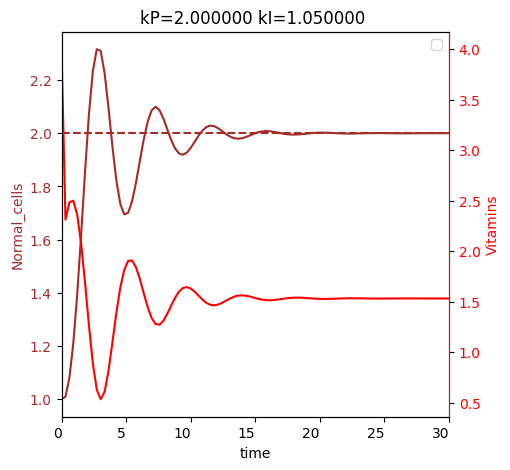

In [11]:
_ = CTLSB.plotDesign(setpoint=2, kP_spec=True, kI_spec=True, min_parameter_value=0.1,
                          num_coordinate=5, max_parameter_value=2, ylabel="Normal_cells")

## Root locus analysis

### Proportional control

In [14]:
print(f"Transfer function: {TRANSFER_FUNCTION}")
print(f"Poles: {TRANSFER_FUNCTION.poles()}")
print(f"Zeros: {TRANSFER_FUNCTION.zeros()}")

Transfer function: 
           933.9
---------------------------
481.9 s^2 + 299.9 s + 401.1

Poles: [-0.31121681+0.85764585j -0.31121681-0.85764585j]
Zeros: []


To simplify these poles we will use a built in function:

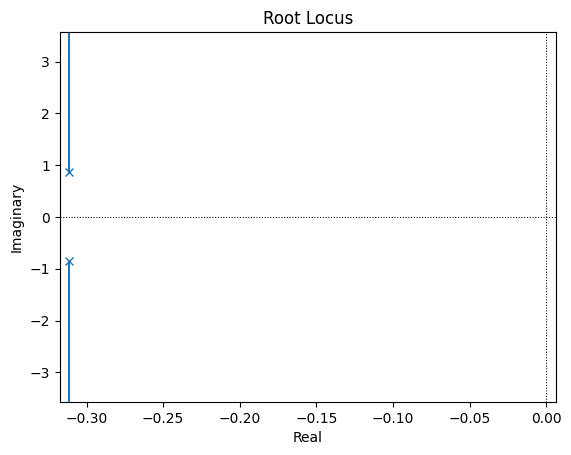

In [17]:
_ = control.root_locus(TRANSFER_FUNCTION, grid=False)

We can see that increasing the proportional control will lead to increasing oscillations, although the system will remain stable. In isolation is seems that [0, 1] will be reasonable values of $k_P$ to try.

### Integral control

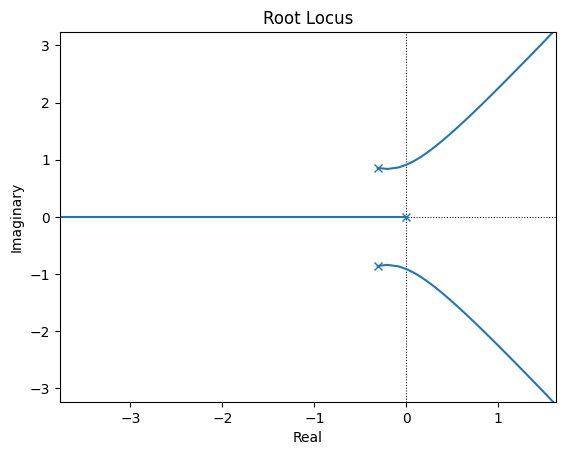

In [18]:
s = control.TransferFunction.s
_ = control.root_locus(TRANSFER_FUNCTION/s, grid=False)

Here we can see that there is a small range of values where integral control will keep our system stable, so there isn't a lot of room to improve settling times. In isolation it seems like [0, 1] is a good range to search for $k_I$.

## Grid search

  1%|          | 1/100 [00:01<01:49,  1.11s/it]Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 24.0182, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 22.5717, mxstep steps taken before reaching tout.
 41%|████      | 41/100 [00:01<00:01, 42.82it/s]Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 20.8015, mxstep steps taken before reaching tout.
Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 28.446, mxstep steps taken before reaching tout.
100%|██████████| 100/100 [00:01<00:00, 52.17it/s]


CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)


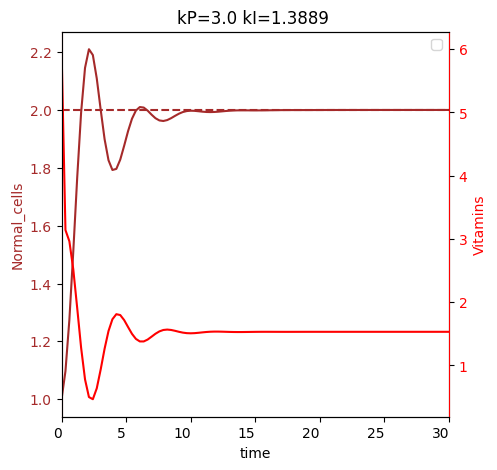

In [19]:
grid = CTLSB.getGrid()
grid.addAxis("kP", min_value=0.1, max_value=3, num_coordinate=10)
grid.addAxis("kI", min_value=0.1, max_value=3, num_coordinate=10)
result = CTLSB.plotGridDesign(grid, setpoint=2, num_restart=1, ylabel="Normal_cells")

We can see alternative designs by examining the ``designs.dataframe``. The ``score`` is the root of the mean square residuals.

In [20]:
result.designs.dataframe

,reason,kP,kI,score
0,Design successful.,3.000000,1.388889,0.029322
1,Design successful.,3.000000,1.711111,0.029357
2,Design successful.,3.000000,2.033333,0.029855
3,Design successful.,3.000000,1.066667,0.030192
4,Design successful.,3.000000,2.355556,0.030620
...,...,...,...,...
95,No design. Cannot simulate the closed loop sys...,0.100000,2.677778,NaN
96,No design. Cannot simulate the closed loop sys...,0.100000,1.711111,NaN
97,No design. Cannot simulate the closed loop sys...,0.100000,2.033333,NaN
98,No design. Cannot simulate the closed loop sys...,0.100000,2.355556,NaN


# 4. Perturbations

## Model of Perturbations

A perturbation is an unknown and undesired signal injected into the closed loop system. There are two types. A disturbance perturbation is added to the control input before it is applied to the open loop system. A noise perturnbation is to the measured output before it is available to the closed loop system. These have slight different effects.

Our model for these undesired signals constants of several parts: a sinusoid, a random variable from a lognormal distribution (which is always non-negative), and a constant. This is formalized as
$$M exp^{N(0, \sigma)} + A sin(F t) + T t + C$$,
where
* $M$ is magnitude of the random noise
* $\sigma$ is standard deviation of the random noise
* $A$ is amplitude of the sine wave
* $F$ is frequency of the sine wave
* $T$  is multiplier of a ramp
* $C$ is a constant
* $t$ is time

## Noise Perturbation

Now we see the effect of a modest level of noise on this design.

In [37]:
%%time
setpoint = 2
noise_spec = ctl.NoiseSpec(random_mag=0.1, random_std=0.1)
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 30, 300), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name="Vitamins", output_name="Normal_cells",
                       noise_spec=noise_spec)
design_result = ctlsb.plotDesign(kP_spec=3.0, kI_spec=1.3889, setpoint=setpoint, ylabel="Normal_cells")

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CPU times: user 225 ms, sys: 8.54 ms, total: 234 ms
Wall time: 2.2 s



/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** No design found!



To understand what is happening, we simulate over a shorter time period.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


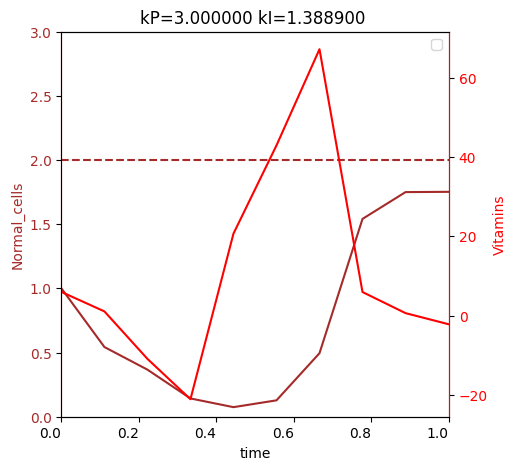

CPU times: user 588 ms, sys: 13.1 ms, total: 601 ms
Wall time: 2.25 s


In [43]:
%%time
setpoint = 2
noise_spec = ctl.NoiseSpec(random_mag=0.1, random_std=0.1)
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 30, 300), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name="Vitamins", output_name="Normal_cells",
                       noise_spec=noise_spec, ylim=[0, 3])
design_result = ctlsb.plotDesign(kP_spec=3.0, kI_spec=1.3889, setpoint=setpoint, ylabel="Normal_cells",
                                times=np.linspace(0, 1, 10))

It seems that the current design overreacts to noise. So, we look for a new design that considers both a filter to moderate noise and differential control to react to trends.

 10%|█         | 51/500 [00:02<00:12, 37.26it/s]Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 24.0117 and h = 5.52497e-07, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 4.70673 and h = 1.32308e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
 24%|██▍       | 121/500 [00:03<00:06, 54.23it/s]Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.72657 and h = 1.41162e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 27.7278 and h = 7.37767e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 12.1743 and h = 6.80986e-156, the corrector convergence test failed repeatedly

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep 

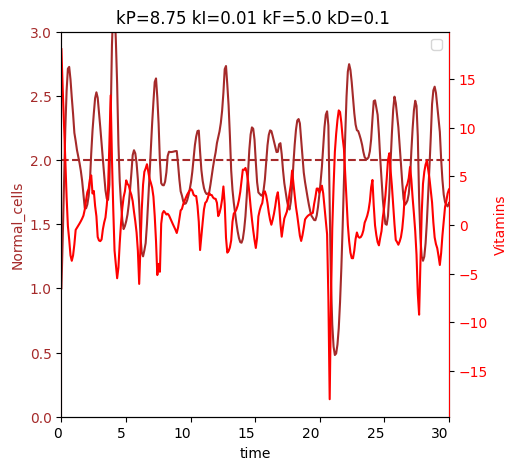

CPU times: user 611 ms, sys: 1.12 s, total: 1.73 s
Wall time: 18.4 s


In [53]:
%%time
setpoint = 2
noise_spec = ctl.NoiseSpec(random_mag=0.1, random_std=0.1)
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 30, 300), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name="Vitamins", output_name="Normal_cells", ylim=[0, 3],
                       noise_spec=noise_spec)
grid = ctlsb.getGrid()
grid.addAxis("kP", min_value=5, max_value=10, num_coordinate=5)
grid.addAxis("kI", min_value=0.0, max_value=0.02, num_coordinate=5)
grid.addAxis("kD", min_value=0.1, max_value=0.2, num_coordinate=5)
grid.addAxis("kF", min_value=4, max_value=5, num_coordinate=4)
design_result = ctlsb.plotGridDesign(grid, setpoint=setpoint, ylabel="Normal_cells")

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 38.4366 and h = 2.05644e-09, the corrector convergence test failed repeatedly or with |h| = hmin.
/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** System is unstable for kP=8.75, kI=0.01, kD=0.1, kF=5.0



CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]
/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** No design found!



CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


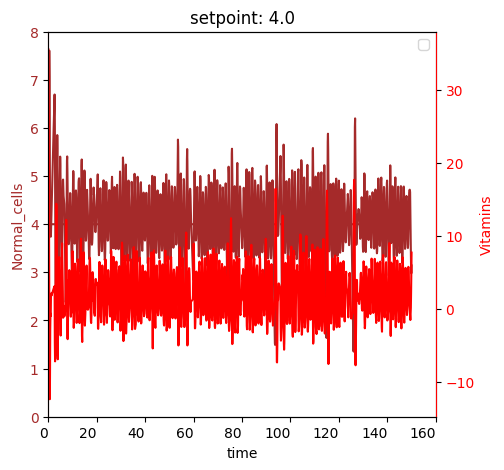

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]


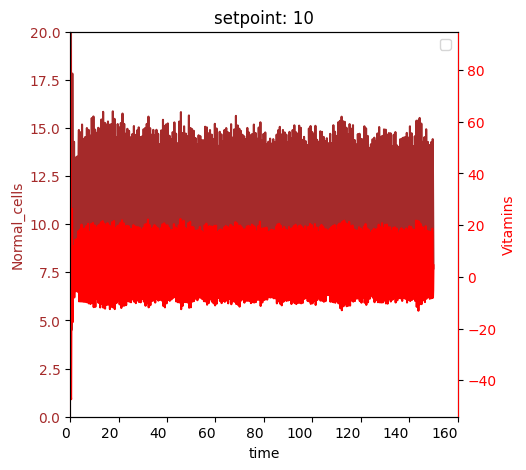

In [66]:
for mult in [0.2, 0.5, 2.0, 5]:
    design_result = ctlsb.plotDesign(kP_spec=ctlsb.kP, kI_spec=ctlsb.kI, kD_spec=ctlsb.kD, kF_spec=ctlsb.kF,
                                 setpoint=mult*setpoint, ylabel="Normal_cells", ylim=[0, 2*mult*setpoint],
                                    times=np.linspace(0, TIMES[-1], len(TIMES)),
                                    title=f"setpoint: {mult*setpoint}")